# Manipulating Layers of ARIA standard GUNW products

**Author**: Brett A. Buzzanga, David Bekaert - Jet Propulsion Laboratory

This notebook documents the methodology used for extracting data and metadata layers of ARIA Geocoded UNWrapped interferogram (**GUNW**) products. It provides command-line and python examples that include visualizations and an application. 

Specifically, we detail the methodology used in extracting:
- product bounding box, amplitude, and coherence,
- imaging geometry, 
- unwrapped phase. 

We then show examples which use the tools to extract based on:
- the full union of the acquisition frames (no bounding box),
- a bounding box of SNWE coordinates in decimal degrees,
- a bounding box in the form of a vector shapefile.

Finally, we demonstrate how to generate a deformation map in a georeferenced coordinate system. 

    
<div class="alert alert-danger">
<b>Both the initial setup (Section A) and download of the data (Section B) should be run at the start of the notebook. However, the numbered sections do not need to be run in numerical order. </b>
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
If the driver is not captured as "netCDF/Network Common Data Format" verify GDAL version is at least 2.5.

The folder containing the ARIA python tools must be in your path. If it's not you can add it like so:
    
`os.environ["PATH"] += os.pathsep + "path_to_tools"`
</div>


## Prep A. Initial setup of the notebook

We start by importing the necessary python libraries, setting the paths we will use to access and store data, and defining a function to plot a layer.

**This step only needs to be ran at the very beginning, but it must be run every time the notebook is restarted.**


In [1]:
import os
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
## add the aria tools to your path
path_tools = os.path.join(os.path.expanduser('~'), 'Software_InSAR', 'ARIA-tools_git', 'tools', 'python')
os.sys.path.append(path_tools)
os.environ["PATH"] += os.pathsep + path_tools

try:
    import shapefile_util as shputil
except:
    raise Exception('ARIA-tools missing from path')

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

## Defining the home and data directories at the processing location
home_dir = os.getcwd()
tutorial_home_dir = os.path.abspath(os.path.join(home_dir, ""))
data_dir = os.path.join(tutorial_home_dir, 'data')
supp_dir = os.path.join(tutorial_home_dir, 'support_docs')
print("home directory: ", tutorial_home_dir)

# data file
fileNames = [os.path.join(data_dir, i) for i in ['S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc', 'S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc']]


# generate all the folders in case they do not exist yet
if not os.path.exists(tutorial_home_dir):
    os.makedirs(tutorial_home_dir)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
os.chdir(tutorial_home_dir)



home directory:  /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct


In [16]:
def plot_layer(path_layers, **kwargs):
    """ path_layers can be a string or a list of up to 4 layers"""
    if not isinstance(path_layers, list):
        path_layers = [path_layers]
    n_layers = len(path_layers)
    if len(path_layers) > n_layers:
        raise Exception('Can only pass <= 4 layers')
    else:
        n_cols = 2 if n_layers == 4 else n_layers 
        n_rows = 2 if n_layers == 4 else 1
        
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,9))
    if not isinstance(axes, np.ndarray):
        axes  = np.array(axes)
    axe       = axes.ravel()
    cmap = plt.cm.Greys_r
    cmap.set_under('black')
    
    for i, ax in enumerate(axe):
        lay_type = os.path.dirname(path_layers[i])
        ds  = gdal.Open(path_layers[i], gdal.GA_ReadOnly)
        arr = ds.ReadAsArray()
        if lay_type.endswith('amplitude'):
            cmap = plt.cm.Greys_r
            cmap.set_under('black')
            ax.imshow(arr, cmap=cmap, vmax=2000, **kwargs)# you may have to adjust vmax for diff scenes
        elif lay_type.endswith('coherence'):
            cmap = plt.cm.Blues
            ax.imshow(arr, cmap=cmap, **kwargs)
        else:
            raise Exception('Layer type not yet supported')
            
        ax.grid(False)
        ax.set_title(os.path.basename(lay_type))

## Part B: Download the data
The GUNW products are packages as netCDF4 files and include both data and meta-data layers such as interferogram amplitude, filtered unwrapped phase, filtered coherence, connected components, perpendicular and parallel baselines, incidence, azimuth and look angles. A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the ARIA website.

Products can be downloaded from the ARIA-products page and ASF DAAC vertex page under beta products. If you know the product filename you can construct the download link by appending the filename to the following URL: https://grfn.asf.alaska.edu/door/download/

For our dataset we are focusing on two adjacent frames from ascending track 124 of Sentinel-1 with an interferogram generated between 20180423 and 20180505. The two frames span 19.661N to 17.420N and 21.158N to 19.086N, respectively, thus it is clear they are adjacent in that they overlap bewteen 19.661N and 19.086N. Together, the two frames cover the entirety of the Big Island of Hawai'i. The interferogram dates capture a coseismic earthquake that occured on May 4, 2018 in the Southeastern corner of the Island (Fig. 1).

<img src="support_docs/Hawaii_shakemap.png" alt="region" width="500">


Given that we already know the product filenames we can download them by constructing the download URLs:
- https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc
- https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc

## 1 Overview of extractProduct.py

### 1.1  Basics

First, we show how to call extractProduct.py and view the help. In the help is a description for each possible input argument. The effects of these arguments will be demonstrated in more detail in the sections that follow. 

Note that multiple ARIA files (`-f`) and layers (`-l`) can be specified by separating the filenames by a **space** or using a wildcard (`-f 'S1*'`), and the layer names with a **comma** (`-l 'azimuth,coherence'`).

In [ ]:
cmd = '-h'
!extractProduct.py {cmd}

### 1.2  Spatial Configuration
Before more advanced operations are performed, the program determine the alignment of the requested frames along the direction of the satellite track. The following plot show the 4 possible configurations for along-track images.

 [[ INSERT PLOT ]]
 
<div class="alert alert-danger">
<b>The user is responsible for ensuring for providing data along a continuous track. Note that along the equator track number gets incremented in the product name but the data itself is still continuous? </b>
</div>



### 1.3 Cropping and Merging
The program then merges and crops based on the user-defined bounding box. If no bounding box is given, the program defaults to use full union of the frames. Alternatively, the user can specify a bounding box of SNWE coordinates or a vector shapefile. 

All layers except the unwrapped phase and connected components are stitched without mathematical processing using GDAL. The offsets betwen connected components and unwrapped phase in adjacent frames are handled using the spatial overlap (for full details see Section [2.3](#Extracting-Unwrapped-Phase)).

### 1.4 
program can handle the extracting of meta-data to full resolution
Unlike many other processing software the ImagingGeometry (e.g., line-of-sight) are provided on 3D grids, the program will automatically extract the 2D version based on topography.
3D grid main data compression. Its smooth on a 3D and can be done on a course resolution. topography enforces the high resolution


### 1.5 
program by defaults makes all virtual files unless requested otherwise.
Explain why we like to use virtual files. However certain layer ywe will need to physical extract. Unw, 3d->2D, coherence, amplitude etc virtual

## 2 Methods

### 2.1 Two-Dimensional Stitching
These layers do not require manipulation of the data to stich, they are average together.
E.g. of layers such as amplitude, coherence, 3D cubes
Not for unwrapped phase

### 2.2 Extracting ImagingGeometry layers 
Stiching of (e.g. line-of-sight, baseline)
Provide a schematic to explain the process (screenshot)
We first stich the 3D cube first from multiple products, then interpolate to the new grid in Spatially then crop to the bbox, then a linear in the vertical to intersect with the DEM
DEM is downloaded on the fly if requested.

### 2.3 Extracting Unwrapped Phase
Explain the minization procedure in overlap regions between product.
Explain what happens to the connected component file and how they are corrected
Could show the bounding box and then color the union, say we will compute the residual between the products in the intersect region

total of connected components of used; offset is applied and only overlap section of master is used.

## 3 Examples

### 3.1 Extract layer without using a bounding box
use example on coherence, explain which other layers would have a similar way of stitching => amplitude similar
Visualization and interpretation

### 3.2 Extract layer with SNWE coordinates
 on how to crop based on bounding box amplitude
 Visualization and interpretation


### 3.3  Extract layer using a shapefile
example could be the incidence angle
Visualization and interpretation
/runCreateWb dMask.py

Instead of using a bbox of coordinates, the user can specify a pre-existing shapefile to crop to.
Here we demonstrate how the input to extractProducy.py should look using the shapefile that was created from the bounding box given in step 2.1. This will again overwrite the raster and associated metadata in the res_dir/amplitude folder. You can check the output with the above plotting call; it should be identical.

**Note** be sure to run cell 2.1 before running the following cell.

Running extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l 'amplitude' -w /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/support_docs --bbox /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/support_docs/ocean_mask/ocean_mask.shp
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

/Users/b

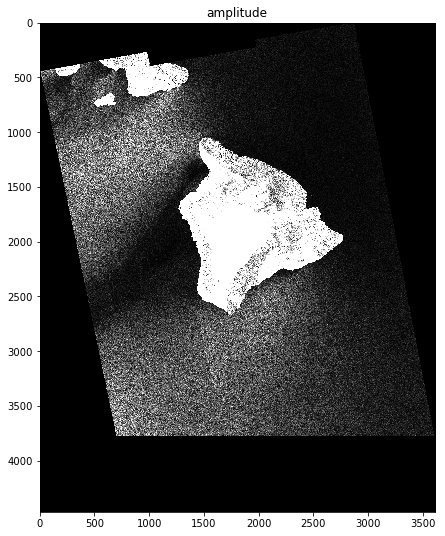

In [17]:
shp    = os.path.join(supp_dir, 'ocean_mask', 'ocean_mask.shp') # all hawaiin islands, from hawaii.gov
layers = ['amplitude']

# cmd    = "-f '{}' -l '{}' -w {}".format(' '.join(fileNames), ','.join(layers), supp_dir, shp)
cmd    = "-f '{}' -l '{}' -w {} --bbox {}".format(' '.join(fileNames), ','.join(layers), supp_dir, shp)
print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
layer_dest = [os.path.join(supp_dir, layer, '20190304_20190226') for layer in layers]
plot_layer(layer_dest)


## Applications

### 4.1 Generation of Georeferenced Displacement Map

In [ ]:
# Extract incidence angle, heading together using the lsit option
# Extract the wavelength from the product (this is not supported by default)
# Generate the ENU conversion and use function to generate the products

# BELOW IS OLD CODE

### 1.1 Merging of the two scenes
Here we demonstrate how to extract the **amplitude** data of the scenes.
Inputting both scenes to extracProduct.py program will automatically merge them.
We also show how to automatically download the required digital elevation model (DEM).
The data will be saved the **res_dir** we set above.

In [ ]:
layers = ['amplitude']
ifgs   = '{} {}'.format(path_ifg1, path_ifg2)
# ifgs   = '{}'.format(path_ifg1)
# cmd    = "--file '{}' --layers '{}' --workdir {} --demfile=Download".format(ifgs, ','.join(layers), res_dir)
cmd    = "--file '{}' --layers '{}' --workdir {}".format(ifgs, ','.join(layers), res_dir)
print ('Running extractProduct.py {}'.format(cmd))
print ('Finished extracting {}'.format(layers))

### 1.1. View Extracted Amplitude
The extraction tool creates a raster with basename of the interferogram dates and no extension in res_dir/amplitude.
It also creates a .vrt file (for use with GDAL, see the GDAL Notebook[LINK]), and an .xml file that is neede for ISCE[LINK] tools such as mdx.py.


Here we demonstrate a quick look at the resulting amplitude data using GDAL and matplotlib.

In [ ]:
path_ifg = os.path.join(res_dir, 'amplitude', '20190304_20190226')


### 1.2. View Product Bounding Bax
Additionally, 2 geojson files (.shp) are created in res_dir/productBoundingBox.
The one with basename of the interferogram dates is bounding box of each scene? and the productBoundingBox_total.shp is total product? (will check later)

In [ ]:
# need to fix import 
os.chdir(path_tools)
from shapefile_util import plot_shapefile
product_bbox  = os.path.join(res_dir, 'productBoundingBox', '20190304_20190226.shp')
product_total = os.path.join(res_dir, 'productBoundingBox', 'productBoundingBox_total.shp')

plot_shapefile(product_bbox)
plot_shapefile(product_total)



## 2. Crop the merged dataset

### 2.1 We'll now crop out most of the water around the Big Island using a lat/lon bounding box

In [ ]:
SNWE = '18.8 20.3 -156.1 -154.5'
layers = ['amplitude']
ifgs   = '{} {}'.format(path_ifg1, path_ifg2)
cmd    = "-f '{}' -l '{}' -w {} --bbox '{}' ".format(ifgs, ','.join(layers), res_dir, SNWE)
print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
print ('Finished cropping {}'.format(layers))

### 2.2 View cropped Amplitude
The cropping routine will have produced a shapefile with our bounding box (user_bbox.shp) in res_dir, and overwritten the files in the res_dir/amplitude.

Let's take a quick look at the cropped data.

In [ ]:
path_ifg = os.path.join(res_dir, 'amplitude', '20190304_20190226')
ds  = gdal.Open(path_ifg, gdal.GA_ReadOnly)
trans = ds.GetGeoTransform(); xsize = ds.RasterXSize; ysize = ds.RasterYSize
extent = [trans[0], trans[0] + xsize * trans[1], trans[3] + ysize*trans[5], trans[3]]
arr = ds.ReadAsArray()

fig, axes = plt.subplots(figsize=(16,9))
cmap = plt.cm.Greys_r
cmap.set_under('black')
# note that you may have to adjust vmax for different scenes
axes.imshow(arr, cmap=cmap, vmax=2000, extent=extent)

In [ ]:
# https://osmdata.openstreetmap.de/data/coastlines.html
ifgs   = '{} {}'.format(path_ifg1, path_ifg2)
cmd    = "-f '{}' -l '{}' -w {} --bbox '{}'".format(ifgs, ','.join(layers), res_dir, shp)
print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
print ('Finished cropping with shapefile {}'.format(layers))